In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,tensorflow

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
tensorflow 0.12.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


텐서플로우에서 제공하는 툴을 이용해 MNIST 데이터를 다운받습니다.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 데이터 탐색

In [3]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x112380470>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x106e84518>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x107519390>)

In [14]:
dir(mnist.train)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_epochs_completed',
 '_images',
 '_index_in_epoch',
 '_labels',
 '_num_examples',
 'epochs_completed',
 'images',
 'labels',
 'next_batch',
 'num_examples']

In [23]:
# 몇개씩이나 들어있나?
print(mnist.train.num_examples, mnist.validation.num_examples, mnist.test.num_examples)

55000 5000 10000


In [4]:
# x 값은 어케 생겼나?
mnist.train.images[1].view()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

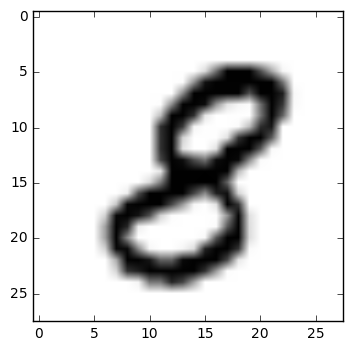

In [11]:
# 5번째 x를 그림으로 그려보면?
plt.imshow(mnist.train.images[5].reshape(28,28), cmap = cm.Greys)
plt.show()

In [13]:
# 5번째 y값은?
mnist.train.labels[5]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

## 텐서플로 구현

In [24]:
import tensorflow as tf

In [6]:
tf.convert_to_tensor(mnist.train.images).get_shape()

TensorShape([Dimension(55000), Dimension(784)])

가중치 텐서와 바이어스 텐서를 만듭니다.

In [7]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

훈련 이미지 데이터를 넣을 플레이스홀더와 소프트맥스 텐서를 만듭니다.

In [8]:
x = tf.placeholder("float", [None, 784])
y = tf.nn.softmax(tf.matmul(x,W) + b)

실제 레이블을 담기위한 텐서와 교차 엔트로피 방식을 이용하는 그래디언트 디센트 방식을 선택합니다.

In [9]:
y_ = tf.placeholder("float", [None,10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

텐서보드 로깅

In [10]:
# 텐서보드에 찍어보려고 삽입한 코드 (신경쓰지 마세요)
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

with tf.name_scope('cross_entropy'):
    variable_summaries(cross_entropy)
with tf.name_scope('W'):
    variable_summaries(W)
with tf.name_scope('b'):
    variable_summaries(b)
    
merged = tf.summary.merge_all()

변수를 초기화하고 세션을 시작합니다.

In [13]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
# Log writer
writer = tf.train.SummaryWriter("./log", sess.graph)

Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


1000의 반복을 수행하고 결과를 출력합니다. 최종 정확도는 91% 정도 입니다.

In [15]:
for i in range(500):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    if i % 100 == 0:
        summary, acc = sess.run([merged, accuracy], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        writer.add_summary(summary, i)